In [1]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, SPSA
from qiskit.aqua.operators import Z2Symmetries

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.providers.aer import QasmSimulator

provider = IBMQ.load_account()

import datetime
import numpy as np
import matplotlib.pyplot as plt

from qoca import QOCA

/home/glados/qoca/venv/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
import warnings;
warnings.filterwarnings('ignore');

In [3]:
def get_LiH_qubit_op_by_bond_length(dist):
    """ Get the qubit operator for Lithium Hydride (LiH) when atoms are at a certain distance apart.
    
    ARGS:
        dist (float): The bondlength of LiH
        
    Returns:
        qubitOp (Operator): The qubit operator representing the
            hamiltonian for LiH at the given bondlength
        num_particles (int): The number of particles
        num_spin_orbitals (int): The number of spin orbitals
        shift (float): The offset to add to get the true energy of the 
            hamiltonian
    """
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [4]:
def exact_eng(distance):
    """ Calculate the ground state energies classically by eigensolver.

    ARGS:
        distanc (float): bond length of LiH

    Returns:
        exact_energies (float[]): array of eigensolver-calculated ground state
            energies across the range in distances
    """
    exact_energies = []

    qubitOp, _, _, shift = get_LiH_qubit_op_by_bond_length(distance)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    return exact_energies

In [5]:
def get_UCCSD_var_form(num_spin_orbitals, num_particles, initial_state):
    vf = UCCSD(
                num_orbitals=num_spin_orbitals,
                num_particles=num_particles,
                initial_state=initial_state,
                qubit_mapping='parity'
    )
    return vf

In [6]:
def get_QOCA_var_form(num_spin_orbitals, initial_state):
    vf = QOCA(
            num_qubits = num_spin_orbitals - 2, 
            reps = 1, 
            initial_state = initial_state
    )
    return vf

In [7]:
def vqe_run_callback(qubitOp, variational_circ, optimizers, opt, backend, shift):
    """ Runs VQE for an individual measurement, with callback to
            record energy variations over each eval

        ARGS:
            qubitOp (Operator): The qubit operator representing the
                hamiltonian for LiH at the given bondlength
            variational_circ (VariationalForm): The parameterized ansatz
                circuit
            optimizers (dict(Optimizer)): initialized optimizer dictionary
            opt (int): index of optimizers
            backend (Backend): simulator or physical quantum backend for
                running variational circuit        
            shift (float): The offset to add to get the true energy of the 
                hamiltonian

        Returns:
            vqe_result (float): (float[]): VQE-estimated ground state energy
            itrs (int): Evaluation number
            vals (float): Mean estimated ground state energy at given eval
            stdevs (float): Standard deviation at eval

    """
    itrs = []
    vals = []
    stdevs = []
    
    def get_eval_result(num_eval, params, mean, std):
        itrs.append(num_eval)
        vals.append(mean)
        stdevs.append(std)
    
    vqe = VQE(qubitOp, variational_circ, optimizers[opt],callback=get_eval_result)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    return vqe_result, itrs, vals, stdevs

In [8]:
def vqe_test(distance, optimizers, backend, ansatz_type):
    """ Main cell for running the LiH VQE pipeline

        ARGS:
            distance (float): bondlength of LiH
            optimizers (dict(Optimizer)): initialized optimizer dictionary
            backend (Backend): simulator or physical quantum backend for
                running variational circuit
            ansatz_type (String): variational circuit type to be
                used in VQE (currently only UCCSD is supported)

        Returns:
            exact_energies (float[]): array of eigensolver-calculated ground state
                energies across the range in distances
            vqe_energies (float[]): VQE-estimated ground state energies for range
                of bond lengths
            converge_itrs (int[]): Evaluation number, up to required evaluations
                to reach minimum
            converge_vals (float[]): : Mean estimated ground state energy at each 
                given eval
            converge_stdevs (float[]): Standard deviation at each eval

    """
    exact_energies = []
    vqe_energies = [[] for i in range(len(optimizers))]
    vqe_result = []
    converge_itrs = [[] for i in range(len(optimizers))]
    converge_vals = [[] for i in range(len(optimizers))]
    converge_stdevs = [[] for i in range(len(optimizers))]
    
    n = 0
    ct = datetime.datetime.now()
    print("Start - ",ct)
    exact_eng(distance)
    for opt in optimizers:
        qubitOp, num_particles, num_spin_orbitals, shift = get_LiH_qubit_op_by_bond_length(distance)
        initial_state = HartreeFock(
                num_spin_orbitals,
                num_particles,
                qubit_mapping='parity'
        )
        if ansatz_type == "UCCSD":
            variational_circ = get_UCCSD_var_form(num_spin_orbitals, num_particles, initial_state)
        elif ansatz_type == "QOCA":
            variational_circ = get_QOCA_var_form(num_spin_orbitals, initial_state)
        else:
            raise RuntimeError("Unsupported ansatz")
            
        vqe_result, converge_itrs[n], converge_vals[n], converge_stdevs[n] = vqe_run_callback(qubitOp, variational_circ, optimizers, opt, backend, shift)
        vqe_energies[n].append(vqe_result)

        n += 1
        ct = datetime.datetime.now()
        print(opt,"Finish - ",ct)

    print("VQE Complete")
    return exact_energies, vqe_energies, converge_itrs, converge_vals, converge_stdevs

In [9]:
def plot_iterations(opt_labels, converge_itrs, converge_vals):
    """ Generates energy convergence plot for each optimizer

        ARGS:
            opt_labels (String[]): names of trials to generate legend
            converge_itrs (int[]): Evaluation number, up to required evaluations
                to reach minimum
            converge_vals (float[]): : Mean estimated ground state energy at each 
                given eval

        Returns: N/A

    """
    for i in range(len(opt_labels)):
        plt.plot(converge_itrs[i], converge_vals[i], label="VQE Energy - %s" % (opt_labels[i]))
    plt.xlabel('Eval Count')
    plt.ylabel('Energy Difference')
    plt.title('VQE Convergence')
    plt.legend()
    plt.show()

In [10]:
backend = BasicAer.get_backend("qasm_simulator")
ds = 1.6
os = {"SLSQP":SLSQP(maxiter=5),
      "COBYLA":COBYLA(maxiter=500, disp=False, rhobeg=1.0, tol=0.2),
      "SPSA":SPSA(maxiter=50, save_steps=1, last_avg=1, c0=1.0, c1=0.1, c2=0.15, c3=0.02, c4=-0.4, skip_calibration=True)}

exact_energies, vqe_energies, converge_itrs, converge_vals, converge_stdevs = vqe_test(distance = ds, optimizers = os, backend = backend, ansatz_type = "QOCA")

Start -  2021-03-17 19:27:03.909691
SLSQP Finish -  2021-03-17 19:27:29.543138
COBYLA Finish -  2021-03-17 19:28:28.241210
SPSA Finish -  2021-03-17 19:31:32.357325
VQE Complete


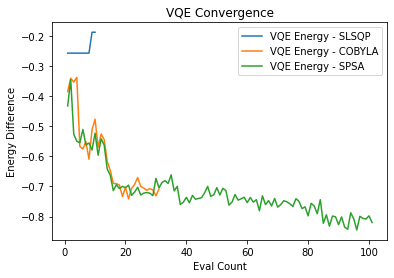

In [11]:
plot_iterations(opt_labels = ["SLSQP","COBYLA","SPSA"], converge_itrs = converge_itrs, converge_vals = converge_vals)